# DPhi Data Sprint 93

In [1]:
# import the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score as acc, f1_score as f1
from warnings import filterwarnings
import shap
shap.initjs()
filterwarnings('ignore')

# read the data
data = pd.read_csv('./train_dataset.csv')
data.sample(6)

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
776,45956,779.419,282.842329,207.051301,1.366050,0.681264,46324,241.894598,0.744203,0.992056,0.950627,0.855228,0.006155,0.002031,0.731414,0.999148,SEKER
430,43828,761.709,268.660049,208.146116,1.290728,0.632260,44224,236.227735,0.802711,0.991046,0.949256,0.879281,0.006130,0.002260,0.773135,0.997908,SEKER
882,34727,698.375,260.626097,170.296807,1.530423,0.757001,35171,210.275509,0.753624,0.987376,0.894746,0.806809,0.007505,0.001962,0.650941,0.996215,DERMASON
1201,57544,939.415,384.565280,191.618322,2.006934,0.867020,58131,270.679324,0.631076,0.989902,0.819398,0.703858,0.006683,0.001012,0.495416,0.994267,HOROZ
497,87672,1140.811,435.167843,261.944578,1.661297,0.798542,89768,334.106955,0.776821,0.976651,0.846532,0.767766,0.004964,0.001064,0.589464,0.979275,CALI
2487,35731,695.011,258.955109,175.866360,1.472454,0.734010,36046,213.293512,0.765151,0.991261,0.929548,0.823670,0.007247,0.002058,0.678432,0.998960,DERMASON


It may not be obvious at first we can see that $\text{AspectRation}\sim\cfrac{\text{MajorAxisLength}}{\text{MinorAxisLength}}$. Another thing to notice is that $\text{AspectRation}\sim(2\times\text{Eccentricity}$). $\text{Area}$ and $\text{ConvexArea}$ do appear similar too. We will try to explore multicollinearity further later.

In [2]:
data.info() # check for null values and types of columns we have

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             2500 non-null   int64  
 1   Perimeter        2500 non-null   float64
 2   MajorAxisLength  2500 non-null   float64
 3   MinorAxisLength  2500 non-null   float64
 4   AspectRation     2500 non-null   float64
 5   Eccentricity     2500 non-null   float64
 6   ConvexArea       2500 non-null   int64  
 7   EquivDiameter    2500 non-null   float64
 8   Extent           2500 non-null   float64
 9   Solidity         2500 non-null   float64
 10  roundness        2500 non-null   float64
 11  Compactness      2500 non-null   float64
 12  ShapeFactor1     2500 non-null   float64
 13  ShapeFactor2     2500 non-null   float64
 14  ShapeFactor3     2500 non-null   float64
 15  ShapeFactor4     2500 non-null   float64
 16  Class            2500 non-null   object 
dtypes: float64(14)

We got no columns with missing values which is helpful

In [3]:
data.describe()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4
count,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000
mean,53313.700400,856.897475,320.613592,202.656362,1.582931,0.750977,54038.396400,253.490510,0.749295,0.987125,0.873166,0.799917,0.006557,0.001714,0.643659,0.995023
std,30159.132787,217.871670,86.553220,46.016190,0.247091,0.091147,30616.360546,60.208996,0.049619,0.004610,0.060540,0.061594,0.001130,0.000594,0.098673,0.004497
min,21348.000000,530.825000,187.168635,131.433059,1.060798,0.333680,21590.000000,164.866970,0.566669,0.949023,0.556766,0.648762,0.002778,0.000590,0.420892,0.949990
25%,36417.750000,702.814000,252.902269,175.667281,1.432151,0.715854,36788.750000,215.333507,0.719277,0.985603,0.831385,0.763542,0.005921,0.001156,0.582996,0.993657
50%,44751.000000,794.969000,296.498005,192.837885,1.549432,0.763847,45288.000000,238.702205,0.759512,0.988283,0.883453,0.802000,0.006634,0.001702,0.643203,0.996385
75%,61028.750000,977.501750,376.493680,216.171558,1.704654,0.809856,61951.000000,278.754756,0.786154,0.989946,0.917277,0.833927,0.007283,0.002176,0.695435,0.997951
max,254616.000000,1985.370000,738.860153,460.198497,2.364017,0.906126,263261.000000,569.374358,0.852841,0.993820,0.986685,0.970516,0.009720,0.003665,0.941900,0.999733


It seems most of the beans's are 98% or above.

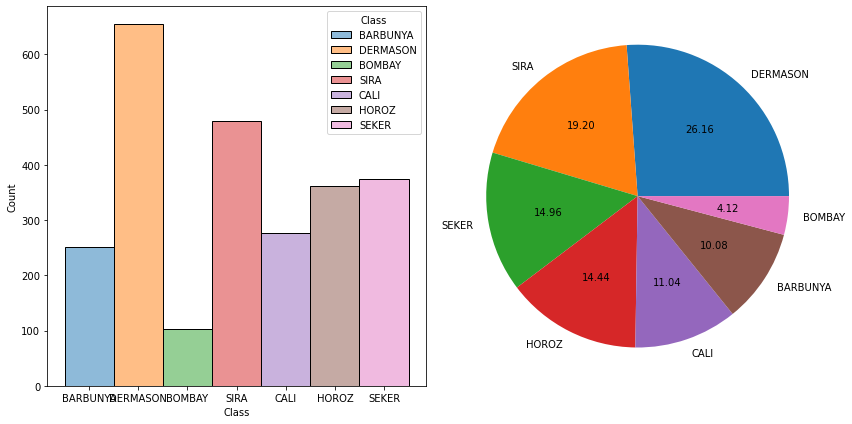

In [4]:
temp = data.Class.value_counts()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
plt.pie(temp.values, labels=temp.index.values, autopct='%.2f')
sns.histplot(data=data, x="Class", stat='count', hue="Class", ax=axes[0])
plt.tight_layout()
plt.show()

It looks like BOMBAY beans make up the small proportion of the overall beans and DERMASON makes the most.

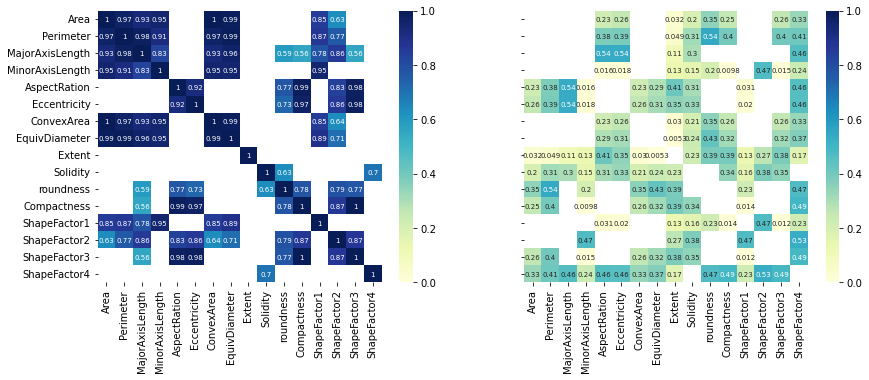

In [5]:
datacorr = data.corr()
fig, axes = plt.subplots(figsize=(14,5), nrows=1, ncols=2, sharey=True)
# sns.heatmap(abs(datacorr), mask=np.triu(np.ones_like(datacorr, dtype=bool)), annot=True)
sns.heatmap(abs(datacorr), mask=abs(datacorr) < 0.55, annot=True, vmin=0, vmax=1, cmap="YlGnBu",
            annot_kws={"fontsize":7}, ax=axes[0])
# plt.show()
sns.heatmap(abs(datacorr), mask=abs(datacorr) >= 0.55, annot=True, vmin=0, vmax=1, cmap="YlGnBu",
            annot_kws={"fontsize":7},ax=axes[1])
plt.show()

The above figure help us find columns that are multicollinear with as few columns as possible.

In [6]:
cols = ['AspectRation', 'Extent', 'Solidity']
data2 = data[cols]
data2.Extent = data2.Extent**2 # to make it more symmetric
data2.head()

,AspectRation,Extent,Solidity
0,1.704873,0.468225,0.982471
1,1.682068,0.459916,0.989811
2,1.550763,0.501904,0.982316
3,1.627155,0.538296,0.985222
4,1.581080,0.598177,0.987574


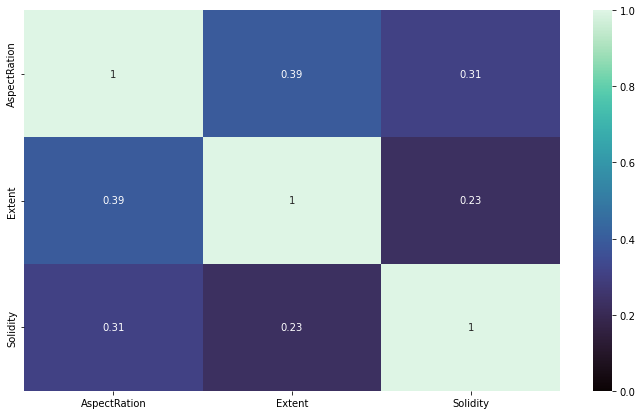

In [7]:
plt.figure(figsize=(12,7))
sns.heatmap(abs(data2.corr()), annot=True, vmin=0, vmax=1, cmap="mako")
plt.show()

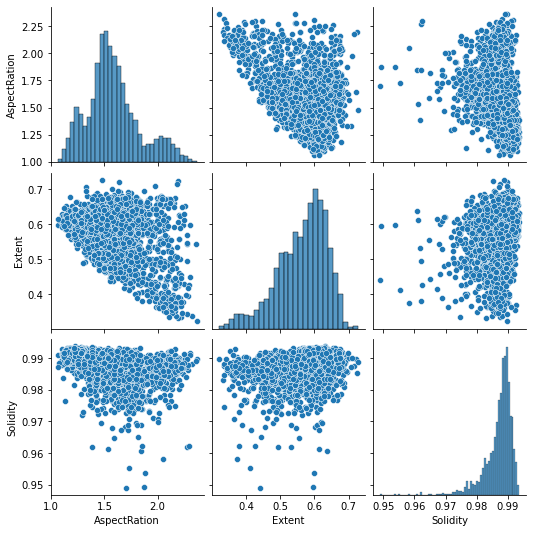

In [8]:
sns.pairplot(data2)

In [9]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor

# def VIF(iter=1):
#     row, col = data.shape
#     X = data.iloc[:,range(col-1)]
#     for _ in range(iter):
#         row, col = X.shape
#         vif = [(X.columns[i],variance_inflation_factor(X.values, i)) for i in range(col)]
#         vif = pd.DataFrame(vif, columns=['Columns', 'VIF'])
#         vif = vif.sort_values(by=['VIF'], ascending=False).reset_index(drop = True).iloc[1:]
#         X = X.loc[:, vif.Columns.values]
#     return vif
# vif_res = VIF(9)
# vif_res

In [10]:
# vif_res.Columns.values
# np.append(vif_res.Columns.values[:2], vif_res.Columns.values[3:])

Let's try fitting some columns

In [11]:
le = LabelEncoder()
y = le.fit_transform(data.Class)
X_train, X_test, y_train, y_test = train_test_split(data2, y, test_size = 0.4, random_state=42) 

Logistic

In [12]:
LogModel = LogisticRegression(multi_class='multinomial',  max_iter=1000)
params = dict(penalty=["elasticnet", "none"], C=[0, 0.1, 0.25, 0.5, 1],
              solver=["newton-cg", "lbfgs", "saga", "sags"])
GScv = GridSearchCV(LogModel, params, verbose=0)
GScv.fit(X_train, y_train)
print(GScv.best_params_)
model1 = GScv.best_estimator_
y_pred = model1.predict(X_test)
print(acc(y_pred, y_test), f1(y_pred, y_test, average="weighted"))

{'C': 0, 'penalty': 'none', 'solver': 'lbfgs'}
0.625 0.6367070459169466


Random Forest CLassifier

In [13]:
rfc = RandomForestClassifier(min_samples_split=0.1, min_samples_leaf=0.1, max_samples=0.8)
params = dict(n_estimators=(150, 175, 200, 250), max_depth=(3,4,5))
GScv2 = GridSearchCV(rfc, params, verbose=1)
GScv2.fit(X_train, y_train)
print(GScv.best_params_)
model2 = GScv2.best_estimator_
y_pred = model2.predict(X_test)
print(acc(y_pred, y_test), f1(y_pred, y_test, average="weighted"))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'C': 0, 'penalty': 'none', 'solver': 'lbfgs'}
0.552 0.6527931446122313


Because we have very few columns, perhaps we have underfitted our models. We will try another approach which is scaling then fitting.

In [14]:
row, col = data.shape
X = data.iloc[:,range(col-1)]

se = StandardScaler()
data_scaled = se.fit_transform(X)
data_scaled = pd.DataFrame(data_scaled, columns=X.columns)
data_scaled.sample(6)

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4
1190,0.576335,0.686470,0.669790,0.772090,0.026432,0.288731,0.568588,0.772839,0.777481,0.512621,0.063797,-0.120746,-1.063351,-0.692096,-0.158464,0.711789
2102,-0.487403,-0.577820,-0.504237,-0.537239,-0.106627,0.168635,-0.493051,-0.527441,-0.942305,0.960486,0.576542,0.010553,0.544559,0.173741,-0.027898,0.579713
2276,-0.580096,-0.758596,-0.984658,-0.182982,-1.501725,-2.041298,-0.582661,-0.663249,0.004924,0.509993,1.120444,1.742488,0.012834,1.736755,1.818419,0.549305
170,0.667172,0.826117,0.769073,0.879937,0.038171,0.298893,0.669959,0.868473,-0.927541,-0.451835,-0.244975,-0.164860,-1.136572,-0.755435,-0.202034,-0.405571
2271,-0.932763,-1.233727,-1.201145,-1.175395,-0.504570,-0.253806,-0.933001,-1.236085,0.927382,0.315341,0.691021,0.431904,1.809604,1.282681,0.400053,0.259454
260,-0.312960,-0.335882,-0.268791,-0.303115,-0.029235,0.239607,-0.316541,-0.284579,-0.529476,0.484204,0.404636,-0.081823,0.194623,-0.076192,-0.119896,0.124226


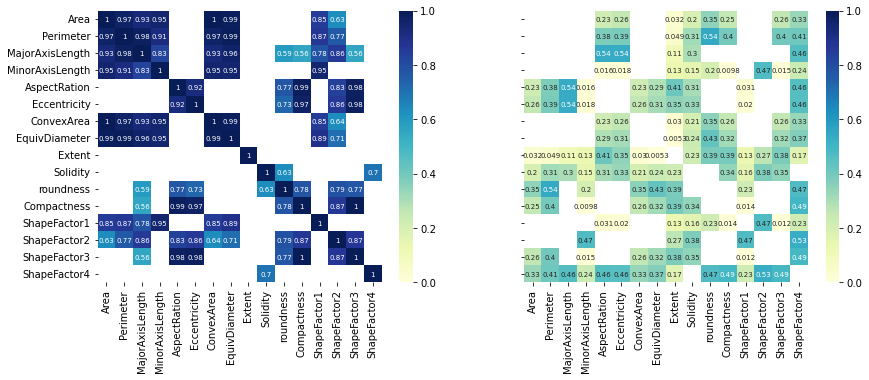

In [15]:
datacorr = data_scaled.corr()
fig, axes = plt.subplots(figsize=(14,5), nrows=1, ncols=2, sharey=True)
# sns.heatmap(abs(datacorr), mask=np.triu(np.ones_like(datacorr, dtype=bool)), annot=True)
sns.heatmap(abs(datacorr), mask=abs(datacorr) < 0.55, annot=True, vmin=0, vmax=1, cmap="YlGnBu",
            annot_kws={"fontsize":7}, ax=axes[0])
# plt.show()
sns.heatmap(abs(datacorr), mask=abs(datacorr) >= 0.55, annot=True, vmin=0, vmax=1, cmap="YlGnBu",
            annot_kws={"fontsize":7},ax=axes[1])
plt.show()

In [16]:
cols = ["MajorAxisLength", "MinorAxisLength", "Solidity", "Perimeter", "roundness", "ShapeFactor4"]
# why these columns? Shap values can explain them
data3 = data_scaled[cols]
data3.shape

(2500, 6)

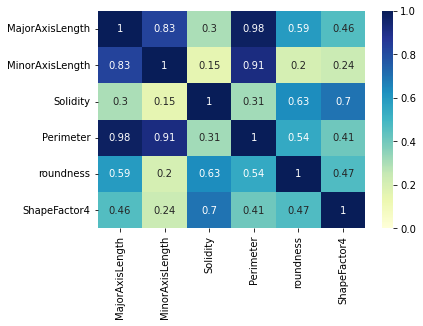

In [17]:
sns.heatmap(abs(data3.corr()),annot=True, vmin=0, vmax=1, cmap="YlGnBu")
plt.show()

In [18]:
X_train, X_test, y_train, y_test = train_test_split(data3, y, test_size = 0.4, random_state=42) # few columns

In [19]:
LogModel = LogisticRegression(multi_class='multinomial',  max_iter=1000)
params = dict(penalty=["elasticnet", "none"], C=[0, 0.1, 0.25, 0.5, 1],
              solver=["newton-cg", "lbfgs", "saga"])
GScv = GridSearchCV(LogModel, params, verbose=0)
GScv.fit(X_train, y_train)
print(GScv.best_params_)
model1 = GScv.best_estimator_
y_pred = model1.predict(X_test)
print(acc(y_pred, y_test), f1(y_pred, y_test, average="weighted"))

{'C': 0, 'penalty': 'none', 'solver': 'saga'}
0.913 0.9124918683257545


In [20]:
rfc = RandomForestClassifier(min_samples_split=0.1, min_samples_leaf=0.1, max_samples=0.8)
params = dict(n_estimators=(150, 175, 200, 250), max_depth=(3,4,5))
GScv2 = GridSearchCV(rfc, params, verbose=1)
GScv2.fit(X_train, y_train)
print(GScv2.best_params_)
model2 = GScv2.best_estimator_
y_pred = model2.predict(X_test)
print(acc(y_pred, y_test), f1(y_pred, y_test, average="weighted"))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'max_depth': 3, 'n_estimators': 250}
0.811 0.8249336687925874


Because we are getting better results after scaling, we will try few models such as XGBClassifier and Stacking

In [21]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
params = dict(base_score=(0.5, 0.75), n_estimators=(150, 175,200))
GScv3 = GridSearchCV(xgb, params, verbose=1)
GScv3.fit(X_train, y_train)
print(GScv3.best_params_)
model3 = GScv3.best_estimator_
y_pred = model3.predict(X_test)
print(acc(y_pred, y_test), f1(y_pred, y_test, average="weighted"))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
{'base_score': 0.5, 'n_estimators': 150}
0.914 0.9136909651951493


In [22]:
stacking = StackingClassifier(estimators=[('log',model1), ('rfc',model2), ('stacking',model3)],
                              final_estimator=LogisticRegression(),
                              stack_method="auto")
stacking.fit(X_train, y_train)
y_pred = stacking.predict(X_test)
print(acc(y_test, y_pred), f1(y_test, y_pred, average="weighted"))

0.915 0.9154973409229256


Finally, we will use the full data with shapely values to determine how our model can actually explain the meaning of our data.

In [23]:
data_train, data_test, y_train, y_test = train_test_split(data_scaled, y, test_size = 0.4, random_state=42) # all columns

In [24]:
xgb2 = XGBClassifier()
xgb2.fit(data_train, y_train)
explainer = shap.TreeExplainer(xgb2)
# shap_values = explainer.shap_values(data_test)[1]
print('Expected Value:', explainer.expected_value)
# pd.DataFrame(shap_values, columns = data_scaled.columns).head()

Expected Value: [-0.15706419 -1.84151623 -0.11326876  1.65448576  0.6213798   0.55795036
  1.0436034 ]


In [25]:
le.classes_

array(['BARBUNYA', 'BOMBAY', 'CALI', 'DERMASON', 'HOROZ', 'SEKER', 'SIRA'],
      dtype=object)

Each expected value acts as a base for which any value at most that base value can be classified as the corresponding class. For example, for a value at most -0.157, it will classified as BARBUNYA

In [26]:
data_test.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4
1447,-0.571706,-0.707955,-0.952756,-0.208129,-1.414451,-1.816261,-0.572240,-0.650743,0.131399,0.137862,0.742549,1.623053,0.039768,1.609412,1.683693,0.849706
1114,0.235442,0.553618,0.810179,-0.073087,1.528519,1.197859,0.242749,0.396273,0.317593,-0.933958,-1.299037,-1.462968,-0.079182,-1.180391,-1.417166,-1.602460
1064,0.940610,1.128815,1.231054,0.931423,0.635133,0.738955,0.952414,1.146057,0.066210,-1.160358,-0.482493,-0.729919,-1.174423,-1.121101,-0.746897,-0.747456
2287,-0.813936,-1.018636,-1.008296,-0.986742,-0.400801,-0.133298,-0.810689,-1.031525,-0.282780,-0.562497,0.387339,0.328967,1.374948,0.925505,0.294243,0.709275
1537,-0.721508,-0.920196,-0.897489,-0.775188,-0.518465,-0.270571,-0.717257,-0.881088,1.046450,-0.757009,0.778119,0.408596,1.009992,0.819007,0.376023,-1.029293


In [27]:
y_pred = xgb2.predict(data_test)
print(data_test.iloc[0,:]) # first row of test data
print(f"The output is {le.inverse_transform(y_test)[0]} and actual is {le.inverse_transform(y_pred)[0]}")

Area              -0.571706
Perimeter         -0.707955
MajorAxisLength   -0.952756
MinorAxisLength   -0.208129
AspectRation      -1.414451
Eccentricity      -1.816261
ConvexArea        -0.572240
EquivDiameter     -0.650743
Extent             0.131399
Solidity           0.137862
roundness          0.742549
Compactness        1.623053
ShapeFactor1       0.039768
ShapeFactor2       1.609412
ShapeFactor3       1.683693
ShapeFactor4       0.849706
Name: 1447, dtype: float64
The output is SEKER and actual is SEKER


In [28]:
shap.initjs()
shap_values = explainer.shap_values(data_test)[0]
shap.force_plot(explainer.expected_value[0], shap_values, data_test)

We see that MajorAxisLength, MinorAxisLength, Solidity, Perimeter, Roundness and ShapeFactor4 are our key features of our model.

Now we will make our predictions on the test data!

In [32]:
test = pd.read_csv('./test_dataset.csv') # read the test data
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             2500 non-null   int64  
 1   Perimeter        2500 non-null   float64
 2   MajorAxisLength  2500 non-null   float64
 3   MinorAxisLength  2500 non-null   float64
 4   AspectRation     2500 non-null   float64
 5   Eccentricity     2500 non-null   float64
 6   ConvexArea       2500 non-null   int64  
 7   EquivDiameter    2500 non-null   float64
 8   Extent           2500 non-null   float64
 9   Solidity         2500 non-null   float64
 10  roundness        2500 non-null   float64
 11  Compactness      2500 non-null   float64
 12  ShapeFactor1     2500 non-null   float64
 13  ShapeFactor2     2500 non-null   float64
 14  ShapeFactor3     2500 non-null   float64
 15  ShapeFactor4     2500 non-null   float64
dtypes: float64(14), int64(2)
memory usage: 312.6 KB


In [33]:
test = pd.DataFrame(se.transform(test), columns=data_scaled.columns) # process the data

In [35]:
# make the predictions and save them in a csv file
predictions = model3.predict(test[X_train.columns])
preds = pd.DataFrame(le.inverse_transform(predictions), columns=["Class"])
preds.to_csv('submission.csv', header=True, index=True)